esmtools works fine with the original data but workers get killed. 
esmtools does not like when I already averaged over years. maybe try to put year dim with datetime coordinates. 

In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr
import esmtools

# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
# import lib_SLXtools_IMHOTEP_2021 as slx

In [2]:
# from dask.distributed import Client
import multiprocessing.popen_spawn_posix
from distributed import Client
c = Client()
c

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32779 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:45133 Dashboard: http://127.0.0.1:32779/status,Cluster Workers: 5 Cores: 10 Memory: 322.12 GB


In [3]:
chunk_size = {"x":133,"y":320}

In [4]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)

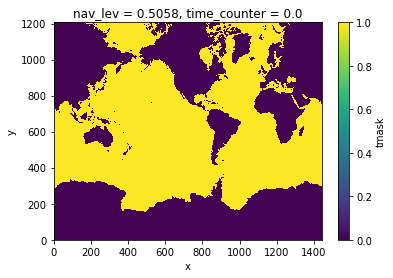

In [5]:
tmask.plot()

In [6]:
path = '/gpfswork/rech/cli/uor98hu/MYDATA/SSH/'

# chunk_size = {"x":500,"y":500}
# chunk_size = {"x":500, "y":607}

dsGAI = xr.open_dataset(path+'GAI/eORCA025.L75-IMHOTEP.GAI_y1980_2018.1m_sossheigCorrected.nc',chunks=chunk_size)
dsAI  = xr.open_dataset(path+'AI/eORCA025.L75-IMHOTEP.AI_y1980_2018.1m_sossheigCorrected.nc', chunks=chunk_size)
dsS   = xr.open_dataset(path+'S/eORCA025.L75-IMHOTEP.S_y1980_2018.1m_sossheigCorrected.nc', chunks=chunk_size)

sshGAI = dsGAI.sossheig
sshAI = dsAI.sossheig
sshS = dsS.sossheig

# convert to annual data
sshGAI =sshGAI.groupby('time_counter.year').mean('time_counter')#.chunk(chunks={"x":500,"y":607, "year":20})
sshAI = sshAI.groupby('time_counter.year').mean('time_counter')#.chunk(chunks={"x":500,"y":607, "year":20})
sshS = sshS.groupby('time_counter.year').mean('time_counter')#.chunk(chunks={"x":500,"y":607, "year":20})

In [7]:
sshGAIprime = sshGAI - sshGAI.mean("year")
sshAIprime  = sshAI  - sshAI.mean("year")
sshSprime   = sshS   - sshS.mean("year")

In [8]:
sshGAIprime

,Array,Chunk
Bytes,543.03 MB,340.48 kB
Shape,"(39, 1207, 1442)","(1, 320, 133)"
Count,11001 Tasks,1716 Chunks
Type,float64,numpy.ndarray


# compute the trends

In [9]:
# years to read data from: 
y1='2005'
# y2='2018'
y2='2017'

# GAI

In [10]:
GAI_4trend = ( sshGAIprime.sel(year=slice(y1,y2))*1000 ).compute()

In [11]:
%%time
lin_GAI = esmtools.stats.linregress(GAI_4trend, dim="year")

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


CPU times: user 7min 9s, sys: 42.1 s, total: 7min 52s
Wall time: 7min 12s


In [12]:
# convert into dataset and save : GAI

ds2save = xr.Dataset(data_vars=dict(linregress=(["y", "x","parameter"], lin_GAI.data)),
                            coords=dict(
                                parameter = (["parameter"],['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])),
                             attrs=dict(description="SSH - GMSL_LinTrnd - time mean, then linear trend over 2005-2017 (mm/yr) calculated over yearly data, saved the 6 fev 2024"))

# ds2save.to_netcdf("/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendGAI_linregress.nc")

In [ ]:
ds2save.to_netcdf("/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/eORCA025.L75-IMHOTEP._y2005_2017.1y_trendGAI_linregress.nc")

# diff

In [29]:

# DIFF_GAI_AI = ( (sshGAIprime - sshAIprime).sel(year=slice(y1,y2))*1000 ).compute()
DIFF_AI_S   = ( (sshAIprime  - sshSprime ).sel(year=slice(y1,y2))*1000 ).compute()
DIFF_GAI_S  = ( (sshGAIprime - sshSprime ).sel(year=slice(y1,y2))*1000 ).compute()

# calculate the trend on yearly data in mm/yr
# trcoeffGAI_AI =  DIFF_GAI_AI.polyfit(dim='year',deg=1).polyfit_coefficients
# trcoeffAI_S   =  DIFF_AI_S.polyfit(dim='year',deg=1).polyfit_coefficients
# trcoeffGAI_S  =  DIFF_GAI_S.polyfit(dim='year',deg=1).polyfit_coefficients


In [30]:
%%time
# lin_GAI_AI = esmtools.stats.linregress(DIFF_GAI_AI, dim="year")
lin_AI_S = esmtools.stats.linregress(DIFF_AI_S, dim="year")
lin_GAI_S = esmtools.stats.linregress(DIFF_GAI_S, dim="year")

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/esmtools/stats.py:394: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


CPU times: user 19min 22s, sys: 2min 6s, total: 21min 28s
Wall time: 19min 6s


In [31]:
# convert into dataset and save : GAI -AI
# ds2save = xr.Dataset(data_vars=dict(linregress=(["y", "x","parameter"], lin_GAI_AI.data)),
#                             coords=dict(
#                                 parameter = (["parameter"],['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])),
#                              attrs=dict(description="SSH - GMSL_LinTrnd - time mean, then linear trend over 2005-2018 (mm/yr) calculated over yearly data, saved the 13 Nov 2023"))

# ds2save.to_netcdf("/gpfswork/rech/cli/uor98hu/MYDATA/SSH/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendGAI_AI_linregress.nc")


# convert into dataset and save : AI -S

ds2save = xr.Dataset(data_vars=dict(linregress=(["y", "x","parameter"], lin_AI_S.data)),
                            coords=dict(
                                parameter = (["parameter"],['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])),
                             attrs=dict(description="SSH - GMSL_LinTrnd - time mean, then linear trend over 2005-2018 (mm/yr) calculated over yearly data, saved the 13 Nov 2023"))

ds2save.to_netcdf("/gpfswork/rech/cli/uor98hu/MYDATA/SSH/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendAI_S_linregress.nc")

# convert into dataset and save : GAI -S

ds2save = xr.Dataset(data_vars=dict(linregress=(["y", "x","parameter"], lin_GAI_S.data)),
                            coords=dict(
                                parameter = (["parameter"],['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])),
                             attrs=dict(description="SSH - GMSL_LinTrnd - time mean, then linear trend over 2005-2018 (mm/yr) calculated over yearly data, saved the 13 Nov 2023"))

ds2save.to_netcdf("/gpfswork/rech/cli/uor98hu/MYDATA/SSH/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendGAI_S_linregress.nc")

In [14]:
help(esmtools.stats.linregress)

Help on function linregress in module esmtools.stats:

linregress(x, y=None, dim='time', nan_policy='none')
    Vectorized applciation of ``scipy.stats.linregress``.
    
    .. note::
    
        This function will try to infer the time freqency of sampling if ``x`` is in
        datetime units. The final slope and standard error will be returned in the
        original units per that frequency (e.g. SST per year). If the frequency
        cannot be inferred (e.g. because the sampling is irregular), it will return in
        the original units per day (e.g. SST per day).
    
    Args:
        x (xarray object): Independent variable (predictor) for linear regression.
            If ``y`` is ``None``, treat ``x`` as the dependent variable and remove
            slope over ``dim``.
        y (xarray object, optional): Dependent variable (predictand) for linear
            regression. If ``None``, treat ``x`` as the predictand.
        dim (str, optional): Dimension to apply linear regr